# Shortest path problem

Finding the shortest path between two pairs of nodes using integer programming solver.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
edgelist_df = pd.DataFrame(
    {
        "node1": ["s", "s", "u", "u", "v"],
        "node2": ["u", "v", "v", "t", "t"],
        "weights": [3, 2, 0.7, 1, 7],
    }
)
edgelist_df

,node1,node2,weights
0,s,u,3.0
1,s,v,2.0
2,u,v,0.7
3,u,t,1.0
4,v,t,7.0


In [7]:
G = nx.from_pandas_edgelist(
    edgelist_df,
    source="node1",
    target="node2",
    create_using=nx.DiGraph(),
    edge_attr=["weights"],
)
nx.is_directed(G)

True

In [10]:
G.edges(data=True)

OutEdgeDataView([('s', 'u', {'weights': 3.0}), ('s', 'v', {'weights': 2.0}), ('u', 'v', {'weights': 0.7}), ('u', 't', {'weights': 1.0}), ('v', 't', {'weights': 7.0})])

In [13]:
G.nodes

NodeView(('s', 'u', 'v', 't'))

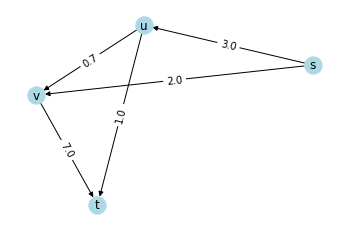

In [50]:
weights = nx.get_edge_attributes(G, "weights")
nx.draw_networkx_edge_labels(G, pos=nx.kamada_kawai_layout(G), edge_labels=weights)
nx.draw_kamada_kawai(G, node_color="lightblue", with_labels=True)

## Shortest path algorithms for unweighted graphs

References:
- https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.weighted

In [35]:
nx.shortest_path(G, source="s", target="t")

['s', 'u', 't']

In [38]:
list(nx.all_shortest_paths(G, source="s", target="t"))

[['s', 'u', 't'], ['s', 'v', 't']]

In [42]:
nx.shortest_path_length(G, source="s", target="t")

2

In [43]:
nx.average_shortest_path_length(G)

0.5833333333333334

In [41]:
nx.has_path(G, source="s", target="t")

True

In [44]:
nx.single_source_shortest_path(G, "s")

{'s': ['s'], 'u': ['s', 'u'], 'v': ['s', 'v'], 't': ['s', 'u', 't']}

In [45]:
nx.single_target_shortest_path(G, "t")

{'t': ['t'], 'u': ['u', 't'], 'v': ['v', 't'], 's': ['s', 'u', 't']}

In [47]:
nx.bidirectional_shortest_path(G, "s", "t")

['s', 'u', 't']

In [49]:
list(nx.all_pairs_shortest_path(G))

[('s', {'s': ['s'], 'u': ['s', 'u'], 'v': ['s', 'v'], 't': ['s', 'u', 't']}),
 ('u', {'u': ['u'], 'v': ['u', 'v'], 't': ['u', 't']}),
 ('v', {'v': ['v'], 't': ['v', 't']}),
 ('t', {'t': ['t']})]

## Shortest path algorithms for weighted graph

In [56]:
nx.dijkstra_path(G, "s", "t")

['s', 'u', 't']

In [57]:
nx.dijkstra_path_length(G, "s", "t")

2

In [58]:
nx.single_source_dijkstra(G, "s")

({'s': 0, 'u': 1, 'v': 1, 't': 2},
 {'s': ['s'], 'u': ['s', 'u'], 'v': ['s', 'v'], 't': ['s', 'u', 't']})

In [60]:
nx.bellman_ford_path(G, "s", "t")

['s', 'u', 't']

In [67]:
nx.astar_path(G, "s", "t")

['s', 'u', 't']

## Formulating the problem using integer programming

We can use binary decision variables $edge_{i,j}$, representing the edge that goes from node i to node j. If $edge_{i,j} = 1$ the shortest path belongs to the path between i and j, 0 otherwise.

In [68]:
from ortools.sat.python import cp_model

shortest_path_model = cp_model.CpModel()

In [69]:
# Create one integer decision variable for each edge.
edge_bool_vars = {}
for edge in G.edges:
    edge_bool_vars[edge[0], edge[1]] = shortest_path_model.NewBoolVar(
        f"edge_{edge[0]}_{edge[1]}"
    )
    print(
        "Creating the boolean variable",
        edge_bool_vars[edge[0], edge[1]],
        "representing if we should travel through",
        (edge[0], edge[1]),
    )

Creating the boolean variable edge_s_u representing if we should travel through ('s', 'u')
Creating the boolean variable edge_s_v representing if we should travel through ('s', 'v')
Creating the boolean variable edge_u_v representing if we should travel through ('u', 'v')
Creating the boolean variable edge_u_t representing if we should travel through ('u', 't')
Creating the boolean variable edge_v_t representing if we should travel through ('v', 't')


The shortest path (in isolation) will have the following properties:
1. starting node has a degree -1
2. ending node has a degree +1
3. all intermediary nodes have degree 0

In [70]:
input_node = "s"
output_node = "t"

In [71]:
# Adding constraint on the nodes
for node in G.nodes:
    in_edges = G.in_edges(node)
    out_edges = G.out_edges(node)
    print("Adding the constraint on node", node)
    print(
        "The node has {} in-edges and {} out-edges".format(
            len(in_edges), len(out_edges)
        )
    )
    equation_at_this_edge = sum(
        edge_bool_vars[edge[0], edge[1]] for edge in in_edges
    ) - sum(edge_bool_vars[edge[0], edge[1]] for edge in out_edges)

    if node == input_node:
        shortest_path_model.Add(equation_at_this_edge == -1)
        print(equation_at_this_edge == -1)
    elif node == output_node:
        shortest_path_model.Add(equation_at_this_edge == +1)
        print(equation_at_this_edge == 1)
    else:
        shortest_path_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge == 0)
    print()

Adding the constraint on node s
The node has 0 in-edges and 2 out-edges
(-(edge_s_u + edge_s_v) + 0) == -1

Adding the constraint on node u
The node has 1 in-edges and 2 out-edges
(edge_s_u + -(edge_u_v + edge_u_t)) == 0

Adding the constraint on node v
The node has 2 in-edges and 1 out-edges
((edge_s_v + edge_u_v) + -edge_v_t) == 0

Adding the constraint on node t
The node has 2 in-edges and 0 out-edges
(edge_u_t + edge_v_t) == 1



The objective of the shortest path problem is to find the path with minimum cost. This can be written as minimising the costs as follow.

In [75]:
# Factor to make everything including costs integer.
factor_to_int = 10

# The objective is to maximise flow.
total_cost = sum(
    int(G.get_edge_data(*edge)["weights"] * factor_to_int)
    * edge_bool_vars[edge[0], edge[1]]
    for edge in G.edges
)
print("Objective is to optimise cost")
print(total_cost)
shortest_path_model.Minimize(total_cost)

Objective is to optimise cost
(((((30 * edge_s_u) + (20 * edge_s_v)) + (7 * edge_u_v)) + (10 * edge_u_t)) + (70 * edge_v_t))


In [76]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(shortest_path_model, solution_printer)

Solution 0, time = 0.03 s, objective = 40


In [78]:
status == cp_model.OPTIMAL

True

In [79]:
result_edges = {}
for edge in G.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_bool_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 1, ('s', 'v'): 0, ('u', 'v'): 0, ('u', 't'): 1, ('v', 't'): 0}

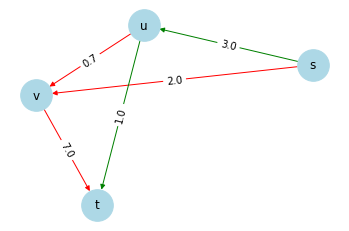

In [89]:
color = ["g" if val == 1 else "r" for val in result_edges.values()]
weights = nx.get_edge_attributes(G, 'weights')
nx.draw_networkx_edge_labels(G, pos=nx.kamada_kawai_layout(G), edge_labels=weights)
nx.draw_kamada_kawai(
    G, edge_color=color, with_labels=True, node_color="lightblue", node_size=1_000
)